# Test Code of Result Analysis

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Make Reference Path

In [32]:
def make_iso_path():
    """
    Function to generate reference paths
    Returns:
        (path_A, path_B, path_C)
    """
    
    Lu = 0.985
    
    # Path A: 5*Lu straight line
    x_A = np.linspace(0, 5*Lu, 500)
    y_A = np.zeros_like(x_A)
    path_A = np.c_[x_A, y_A]
    
    # Path B: Square with side length 5*Lu
    x_B1 = np.linspace(0, 5*Lu, 500)
    y_B1 = np.zeros_like(x_B1)
    y_B2 = np.linspace(0, -5*Lu, 500)
    x_B2 = np.ones_like(y_B2) * 5 * Lu
    x_B3 = np.linspace(5*Lu, 0, 500)
    y_B3 = np.ones_like(x_B3) * -5 * Lu
    y_B4 = np.linspace(-5*Lu, 0, 500)
    x_B4 = np.zeros_like(y_B4)
    x_B = np.concatenate([x_B1, x_B2, x_B3, x_B4])
    y_B = np.concatenate([y_B1, y_B2, y_B3, y_B4])
    path_B = np.c_[x_B, y_B]
    
    # Path C: Straight line + arc
    x_C1 = np.linspace(0, 5*Lu, 500)
    y_C1 = np.zeros_like(x_C1)
    theta_list = np.linspace(0, np.pi/2, 500)
    x_C2 = 5*Lu*(1+np.sin(theta_list))
    y_C2 = 5*Lu*(np.cos(theta_list)-1)
    x_C = np.concatenate([x_C1, x_C2])
    y_C = np.concatenate([y_C1, y_C2])
    path_C = np.c_[x_C, y_C]
    
    return path_A, path_B, path_C

(path_A, path_B, path_C) = make_iso_path()


## Examine ISO path test

In [33]:
df = pd.read_csv("/home/decwest/decwest_workspace/dwpp_test_simulation/data/dwpp/RPP_Composite_20251211_202631.csv")
t = df["sec"] - df["sec"][0]

In [34]:
df.head()

,sec,nsec,x,y,yaw,v_cmd,w_cmd,battery_v,battery_i,v_real,w_real,imu_ax,imu_ay,imu_az,imu_vx,imu_vy,imu_vz,v_nav,w_nav,velocity_violation
0,1.765452e+09,170826752.0,0.000000,0.000000e+00,0.000000,0.83,1.841801e-18,25.200001,-0.294,0.000000,0.000000,1.063026,0.107739,9.512163,0.008522,-0.045940,0.007191,0.0415,1.841801e-18,False
1,1.765452e+09,203036160.0,0.000000,0.000000e+00,0.000000,0.83,1.841801e-18,25.200001,-0.294,0.000000,0.000000,1.292869,-0.007183,10.081983,0.027164,-0.001332,-0.003462,0.0415,1.841801e-18,False
2,1.765452e+09,240848640.0,0.000000,-4.440892e-16,0.000000,0.83,-7.353463e-16,25.200001,-0.293,0.000000,0.000000,1.395820,-0.050278,9.622296,0.015846,-0.046472,-0.003196,0.0830,1.841801e-18,False
3,1.765452e+09,263458816.0,0.000000,-4.440892e-16,0.000000,0.83,-7.353463e-16,25.200001,-0.293,0.013250,-0.000002,1.309628,0.035913,8.291120,0.015846,0.072172,-0.013183,0.1245,-7.353463e-16,False
4,1.765452e+09,288831744.0,0.000729,2.653947e-08,0.000267,0.83,3.221557e-08,25.200001,-0.293,0.019876,0.026716,1.934515,-0.363919,9.088390,0.021838,-0.084822,-0.017044,0.1245,-7.353463e-16,False


## Plot Path

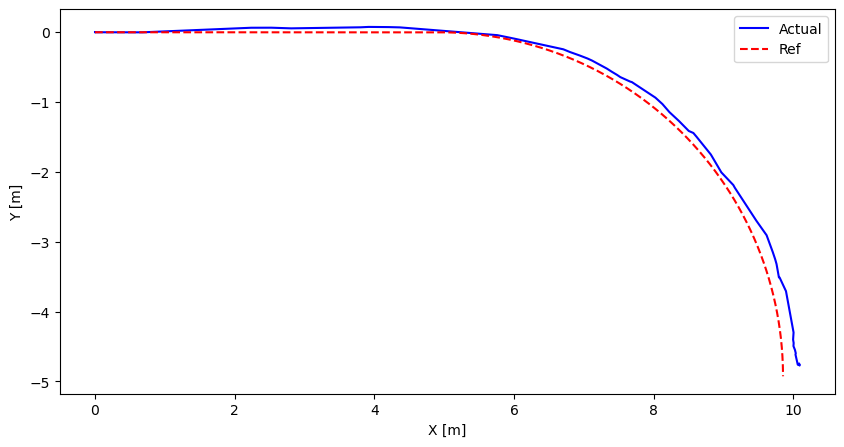

In [40]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(df["x"], df["y"], label="Actual", color="blue")
ax.plot(path_C[:, 0], path_C[:, 1], label="Ref", linestyle="--", color="red")
ax.set_aspect('equal')
ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.legend()
plt.show()

## Plot Velocity

Linear

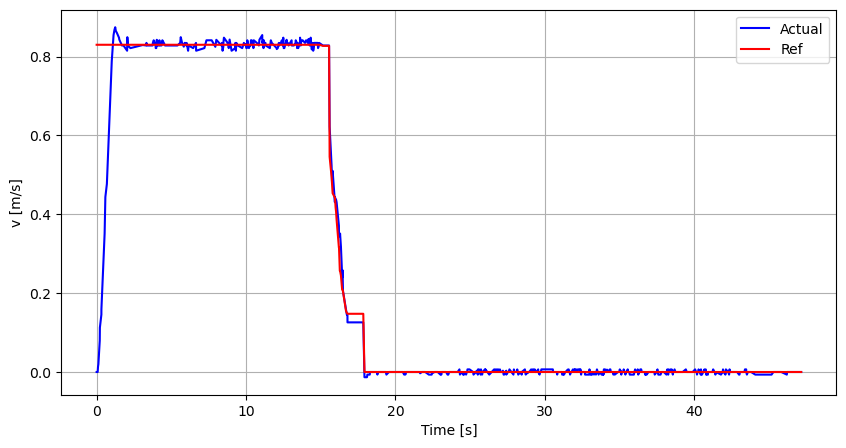

In [36]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(t, df["v_real"], label="Actual", color="blue")
ax.plot(t, df["v_cmd"], label="Ref", color="red")
ax.set_xlabel("Time [s]")
ax.set_ylabel("v [m/s]")
ax.grid()
ax.legend()
plt.show()

Angular

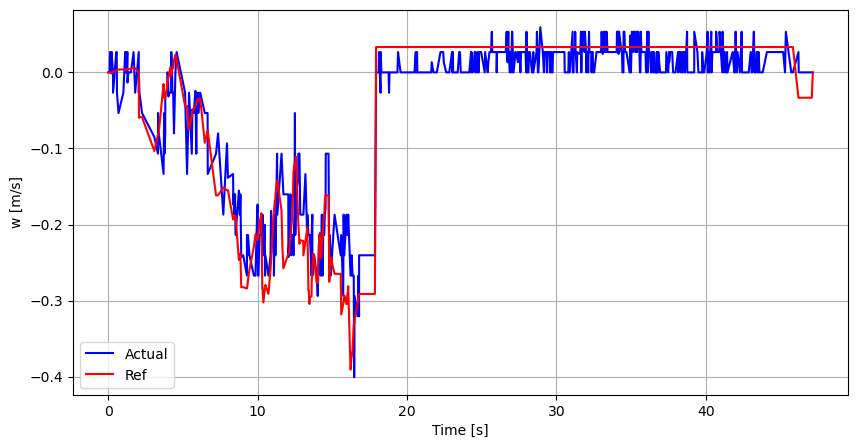

In [37]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(t, df["w_real"], label="Actual", color="blue")
ax.plot(t, df["w_cmd"], label="Ref", color="red")
ax.set_xlabel("Time [s]")
ax.set_ylabel("w [m/s]")
ax.grid()
ax.legend()
plt.show()

Near the goal, the robot did not finish its navigation for a while, I will fix this

## Plot current

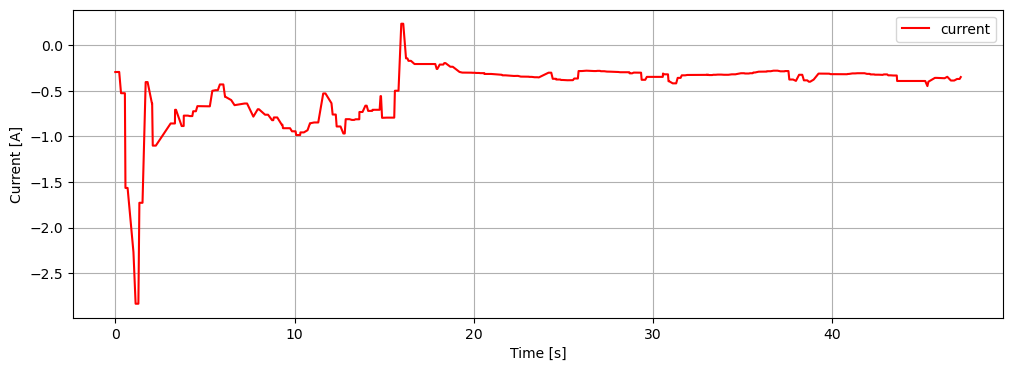

In [38]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 1, 1)
ax.plot(t, df["battery_i"], label="current", color="red")
# ax.set_aspect('equal')
ax.set_xlabel("Time [s]")
ax.set_ylabel("Current [A]")
ax.grid()
ax.legend()
plt.show()

Maybe there is an offset...? about -0.3 [A]

## Calc RMSE

In [ ]:
from scipy.spatial.distance import cdist

def calc_rmse(robot_path: np.ndarray, path: np.ndarray) -> float:

    # Compute the distances between each point on the robot trajectory and each point on the path at once (using scipy's cdist)
    # distance_matrix has shape = (number of points in the robot trajectory, number of points in the path)
    distance_matrix = cdist(robot_path, path, metric='euclidean')

    # Take the minimum along the row direction to extract the minimum distance for each robot point
    min_distances = np.min(distance_matrix, axis=1)

    # Compute RMSE
    rmse = np.sqrt(np.mean(min_distances**2))
    
    return rmse


In [41]:
robot_x = df["x"].to_numpy()
robot_y = df["y"].to_numpy()
robot_path = np.c_[robot_x, robot_y]

rmse = calc_rmse(robot_path, path_C)
print(f"RMSE: {rmse:.4f} m")

RMSE: 0.2005 m
